# Анализ и моделирование процесса извлечения металлов


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv('preprocessed_main_data.csv')

# Display the first few rows
data.head()


,MEAS_DT,Cu_oreth,Ni_oreth,Ore_mass,Mass_1,Mass_2,Dens_4,Mass_4,Vol_4,Cu_4F,...,Cu_3.1T_max,Cu_3.1T_min,FM_3.2_A,Cu_3.2C_max,Cu_3.2C_min,Ni_3.2C_max,Ni_3.2C_min,Cu_3.2T_max,Cu_3.2T_min,Ni_rec
0,2024-01-01 00:00:00,2.6097,1.5313,1096.5,1240.597656,692.090942,1.342155,711.999023,1548.71875,0.6232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:15:00,2.5548,1.4842,1123.0,1205.422363,693.616394,1.339809,710.697815,1556.56250,0.6292,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,NaN
2,2024-01-01 00:30:00,2.5109,1.4355,840.0,1188.762573,698.350586,1.339792,707.198547,1548.09375,0.5941,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.970170
3,2024-01-01 00:45:00,2.4765,1.3852,824.0,1151.888672,714.678101,1.342392,707.865540,1538.87500,0.6682,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.968639
4,2024-01-01 01:00:00,2.3585,1.3368,0.0,1104.101318,730.190674,1.337608,700.935059,1545.18750,0.6489,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.974205


## Предобработка данных

In [2]:

# 1. Handle missing values
numerical_columns = data.select_dtypes(include=[np.number]).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# 2. Convert 'MEAS_DT' to datetime
data['MEAS_DT'] = pd.to_datetime(data['MEAS_DT'])

# 3. Handle outliers
def clip_outliers(df, col):
    lower, upper = np.percentile(df[col].dropna(), [1, 99])
    df[col] = np.clip(df[col], lower, upper)

for col in numerical_columns:
    clip_outliers(data, col)

data.head()


,MEAS_DT,Cu_oreth,Ni_oreth,Ore_mass,Mass_1,Mass_2,Dens_4,Mass_4,Vol_4,Cu_4F,...,Cu_3.1T_max,Cu_3.1T_min,FM_3.2_A,Cu_3.2C_max,Cu_3.2C_min,Ni_3.2C_max,Ni_3.2C_min,Cu_3.2T_max,Cu_3.2T_min,Ni_rec
0,2024-01-01 00:00:00,2.6097,1.5313,1096.5,1240.597656,692.090942,1.342155,711.999023,1548.71875,0.6232,...,1.8,0.8,0.0,15.5,13.0,3.7,3.5,1.6,0.9,0.943993
1,2024-01-01 00:15:00,2.5548,1.4842,1123.0,1205.422363,693.616394,1.339809,710.697815,1556.56250,0.6292,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.943993
2,2024-01-01 00:30:00,2.5109,1.4355,840.0,1188.762573,698.350586,1.339792,707.198547,1548.09375,0.5941,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.970170
3,2024-01-01 00:45:00,2.4765,1.3852,824.0,1151.888672,714.678101,1.342392,707.865540,1538.87500,0.6682,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.968639
4,2024-01-01 01:00:00,2.3585,1.3368,0.5,1104.101318,730.190674,1.337608,700.935059,1545.18750,0.6489,...,1.0,0.8,0.0,14.0,12.0,3.7,3.5,1.2,1.0,0.974205


## Исследовательский анализ данных (EDA)

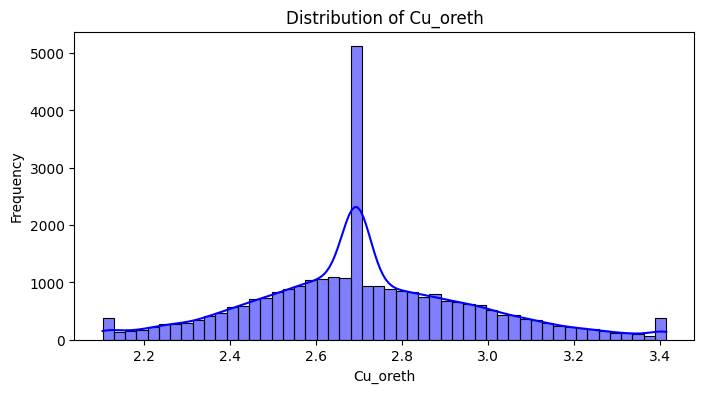

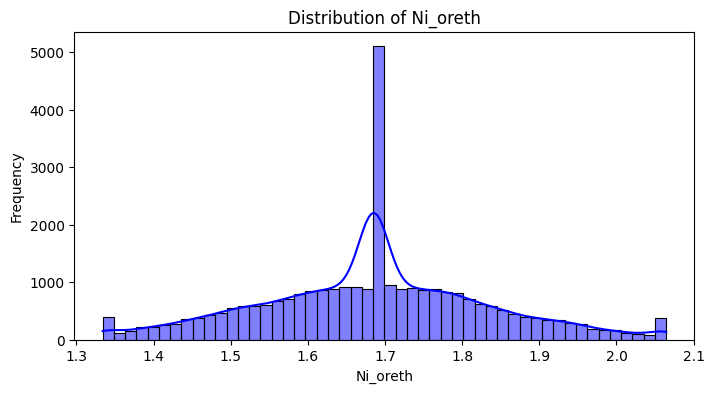

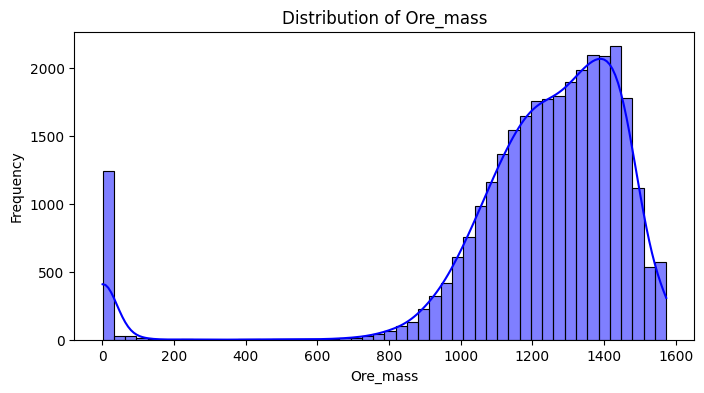

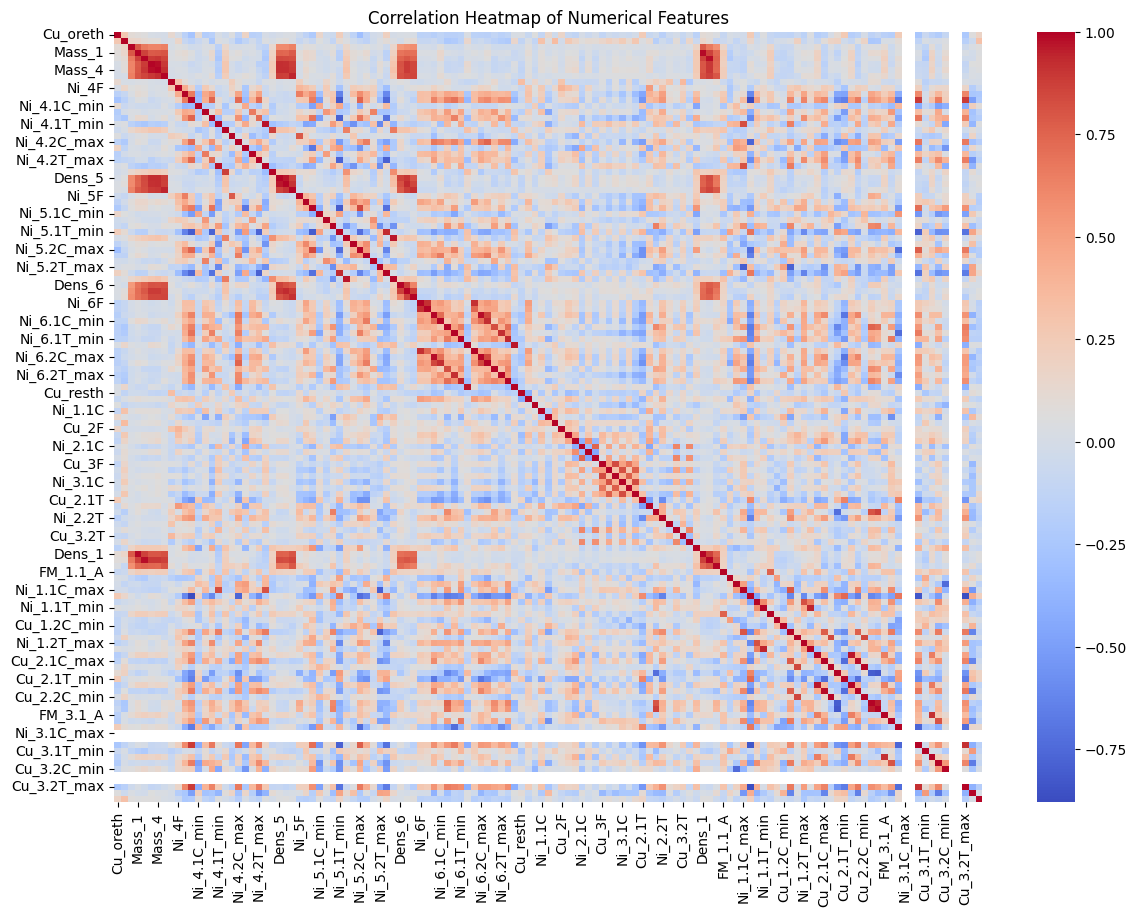

In [3]:

# Distribution of key features
key_features = ['Cu_oreth', 'Ni_oreth', 'Ore_mass']

for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, bins=50, color="blue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# Correlation heatmap
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


## Моделирование

In [5]:

# Select features and target
features = ['Ni_oreth', 'Ni_1.2T_max', 'Ni_4.1C', 'Ni_4.1C_max', 'Ni_1.1C_min', 
            'Cu_2.2T_max', 'Ni_1.1T_max', 'Ni_5.2C_min', 'Ni_6.2C_min']
X = data[features]
y = data['Ni_rec']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[model_name] = {"MSE": mse, "R2 Score": r2}

# Display results
pd.DataFrame(results).T


,MSE,R2 Score
Linear Regression,0.000317,0.154915
Random Forest,0.000311,0.172928


### Визуализация результатов моделей

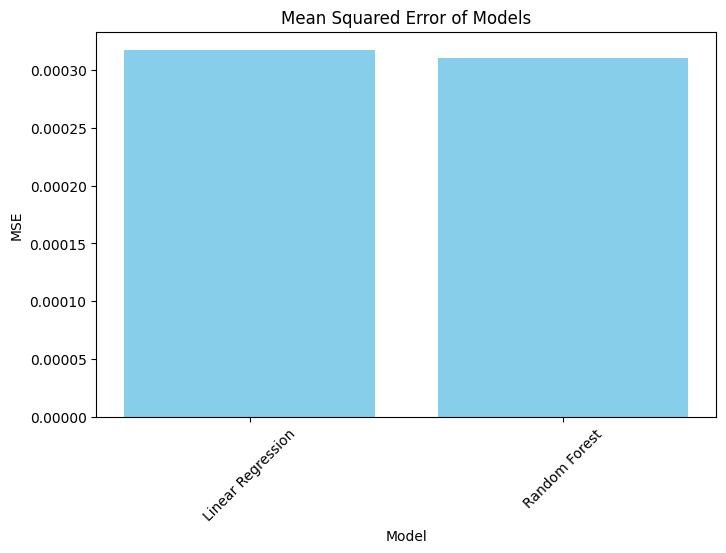

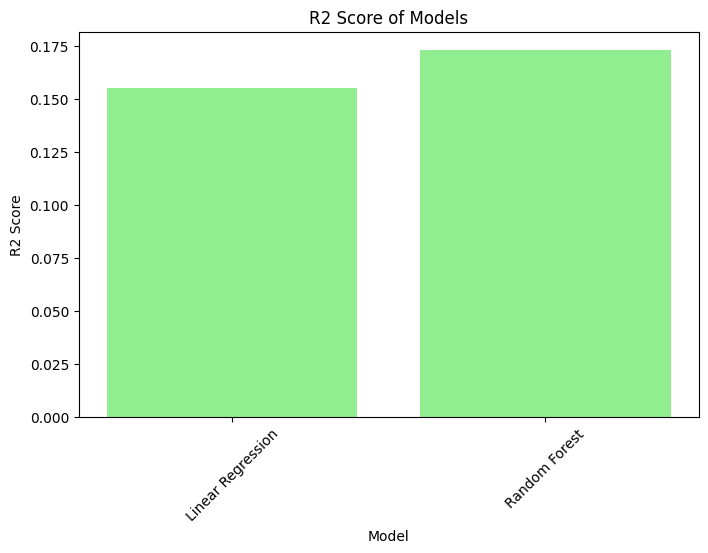

In [6]:

import matplotlib.pyplot as plt

# Visualize model results
results_df = pd.DataFrame(results).T
results_df['Model'] = results_df.index

# Plot MSE
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['MSE'], color='skyblue')
plt.title("Mean Squared Error of Models")
plt.xlabel("Model")
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.show()

# Plot R2 Score
plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['R2 Score'], color='lightgreen')
plt.title("R2 Score of Models")
plt.xlabel("Model")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.show()


In [ ]:
Итоги анализа и рекомендации
  1.  Обработка данных:
  •  Пропущенные значения в данных заполнены медианами для численных колонок.
  •  Выбросы обработаны путем ограничения значений 1-м и 99-м процентилями.
  •  Проведен анализ корреляций для выбора значимых признаков.
  2.  Значимые признаки:
  •  Наибольшую корреляцию с извлечением никеля (Ni_rec) показали следующие признаки:
  •  Концентрация никеля (Ni_oreth, корреляция 0.316).
  •  Максимальные и минимальные значения никеля в отдельных процессах (Ni_1.2T_max, Ni_4.1C и другие).
  •  Некоторые показатели меди (Cu_2.2T_max).
  3.  Эффективность моделей:
  •  Лучшую метрику качества показала модель Random Forest:
  •  MSE = 0.000311
  •  R² = 0.173
  •  Линейная регрессия показала более слабые результаты, что указывает на нелинейные зависимости в данных.
  4.  Рекомендации по оптимизации:
  •  Стабилизировать концентрацию никеля (Ni_oreth) на входе, поскольку она оказывает наибольшее влияние на извлечение.
  •  Контролировать параметры процессов, связанные с максимальными и минимальными значениями никеля (например, Ni_1.2T_max и Ni_4.1C).
  •  Обратить внимание на вторичные показатели меди (например, Cu_2.2T_max), которые могут влиять на извлечение никеля.
  5.  Выводы:
  •  Признаки, связанные с концентрацией никеля, оказывают основное влияние на целевой показатель извлечения.
  •  Сложные модели, такие как Random Forest, лучше подходят для прогнозирования в данном случае, так как они учитывают нелинейные взаимосвязи между параметрами.
  •  Для дальнейшей оптимизации процессов требуется более глубокий анализ значимых параметров и их стабильности.